In [3]:
import emcee 
import corner
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io
import math 

%matplotlib inline

# Load Data & Constants

In [4]:
""" In this project we're aiming to parametrize/estimate the Temperature of WISE-0855 using
    an MCMC algorithm (metropolis rule)
    
    Author: Anastasios Tzanidakis
    """
#Load data: 
Data=np.loadtxt('/data.dat')
#Variables: 
Lamda=Data[:,0]*10**4 #A
log_flux=Data[:,1] #log_flux
error=Data[:,2] #

# Define Models

In [2]:
#Planck Function -- Black Body Curve Log()
def log_pf(Lamda,Temp,logfactor):
    
    #Define Constants: 
    h=6.6260755*10**-27 #erg s 
    k=1.380658*10**-16 #erg/k
    c=2.998*10**18 #A/s

    f1=2*h*c**2
    f2=(f1)/(Lamda**5)
    f3=np.e**(h*c/(Lamda*k*Temp))-1
    f4= f2 / f3
    log_flux=np.log10(f4) + logfactor
    return log_flux#


# We define a likelyhood -- and prior for normaly distributed data
def logpost(error,Lamda,Temp,logfactor,log_flux):
    
    #Prior Boundaries: 
    pi_tmin = 50 #lowest temperature
    pi_tmax = 600 #highest temperature
    pi_logfmin=-100 
    pi_logfmax=100 #(log(small number) ~ -5)
    
    
    N=len(error) #length of data points
    Residual= log_flux - log_pf(Lamda,Temp,logfactor)
    print Temp

    # Calculations -- '
    if ((pi_tmin<Temp) & (Temp<pi_tmax)) & ((logfactor>pi_logfmin) & (logfactor<pi_logfmax)):
        logpi=0
        #loglike = -N*.5*np.log10(2*np.pi) - np.sum(np.log10(error)) - 0.5*np.sum((Residual/error)**2)
        loglike = np.sum((Residual/error)**2)
        return loglike + logpi
    
    else: #when we get temepratures outside posterior the values become negative inifinitely large... hence
        logpi = 1000000000000
        print 'second'
        return logpi
        
#Define Metropolis rule! 
def Metropolis(tri_temp,tri_logf,in_temp,in_logf):
    DF1=logpost(error,Lamda,tri_temp,tri_logf,log_flux)
    DF2=logpost(error,Lamda,in_temp,in_logf,log_flux)
    P=np.e**(-.5 * (DF1-DF2))
    return P



# Define MCMC -- Metropolis Rule

In [ ]:
# Parameters for set-up: 
T = []  
logf = []  
Ltrial = []  
alltemps = []  
alllogfs = []  

#Define Jump size: 
tempjump = 5  # Delta Temp -- Jump size 
logfjump = .1  # Delta Logf -- Jump size

#Define initial suggestions: 
in_temp = 200  # Initial suggested temperature
in_logf = 1  # Initial suggested logf

#loop size 
MCMC = 10000  

#Begin loop 
i = 0
while True:
    # propose trial parameters 
    tri_temp = np.random.normal(in_temp, tempjump)
    tri_logf = np.random.normal(in_logf, logfjump)
    print('initial temp: {0}, initial logf: {1}'.format(in_temp, in_logf))
    # if delta probs of trial/initial > 1, accept
   
    metrodecision = Metropolis(tri_temp, tri_logf, in_temp, in_logf)
    print metrodecision
    
    if  metrodecision >= 1:
        print("accept")
        i = i + 1 
        # add trials to lists
        T.append(tri_temp)
        print T #check for consistency 
        
        logf.append(tri_logf)
        Ltrial.append(logpost(error, Lamda, tri_temp,tri_logf,log_flux))
        # replace initials with trials
        in_temp = tri_temp
        in_logf = tri_logf

    # if delta probs < 1, accept with probability 
    elif metrodecision < 1:
        # print("prob is less than one")
        # if random draw is less than probability, accept
        if np.random.uniform(0, 1) < Metropolis(tri_temp, tri_logf, in_temp, in_logf):
            print("accept")
            i = i + 1 
            T.append(tri_temp)
            logf.append(tri_logf)
            Ltrial.append(Metropolis(tri_temp, tri_logf, in_temp, in_logf))
            in_temp = tri_temp
            in_logf = tri_logf
        # if random draw is more than probability, reject       
    if i == MCMC:
        break

# Markov Chain

(array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 <a list of 6 Text yticklabel objects>)

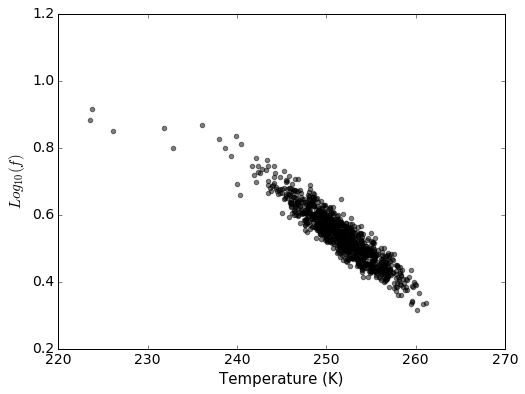

In [237]:
#Figure 1 : 
plt.figure(figsize=(8,6))

plt.scatter(T,logf,alpha=0.5,color='k')
plt.xlim(220,270)
plt.xlabel('Temperature (K)',size=15)
plt.ylabel('$Log_{10}(f)$',size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Converging Chi Square

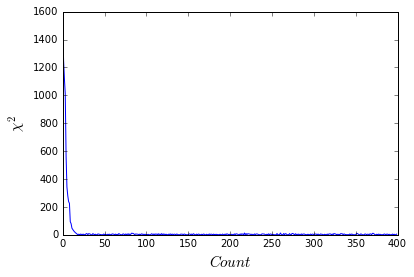

In [269]:
plt.plot(Ltrial[0:400])
plt.ylabel('$\chi^{2}$',size=15)
plt.xlabel('$Count$',size=15)

# Results

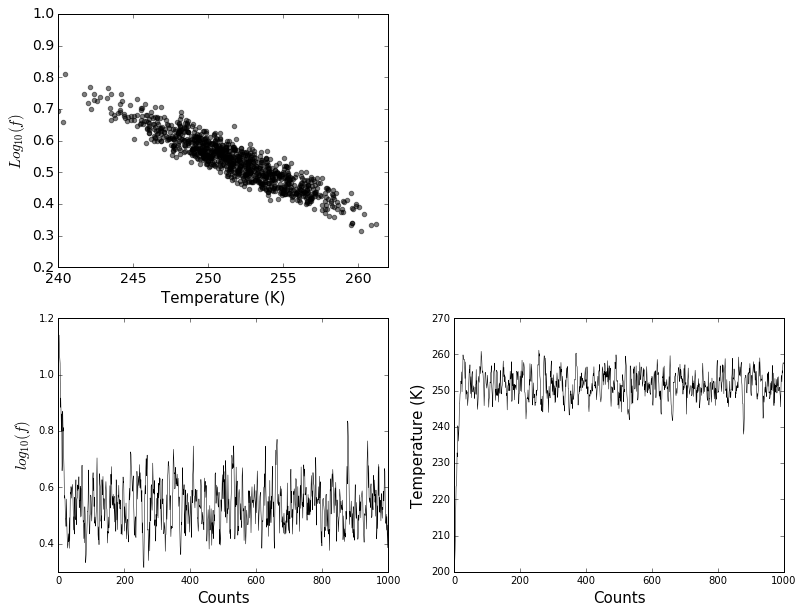

In [276]:
plt.figure(figsize=(13,10))

plt.subplot(224)
plt.plot(T,color='k',lw=0.5)
plt.xlabel('Counts',size=15)
plt.ylabel('Temperature (K)',size=15)

plt.subplot(223)
plt.plot(logf,color='k',lw=0.5)
plt.xlabel('Counts',size=15)
plt.ylabel('$log_{10}(f)$',size=15)

plt.subplot(221)
plt.scatter(T,logf,alpha=0.5,color='k')
plt.xlim(240,262)
plt.ylim(0.2,1)
plt.xlabel('Temperature (K)',size=15)
plt.ylabel('$Log_{10}(f)$',size=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Corner Plot Distributions

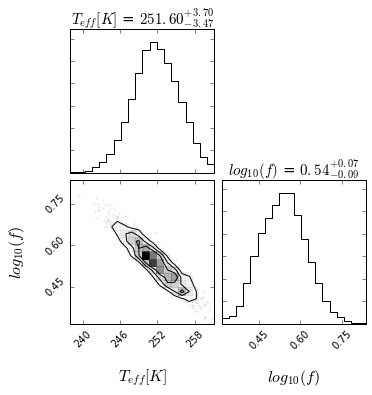

In [301]:
data = np.column_stack([T[50:], logf[50:]])
figure = corner.corner(data,smooth1d = True, show_titles = True, plot_contours = True,color='black', 
                       labels = ["$T_{eff}[K]$", "$log_{10}(f)$"], title_kwargs={"fontsize": 15}, 
                       label_kwargs={"fontsize": 16})

# Mixing Plots

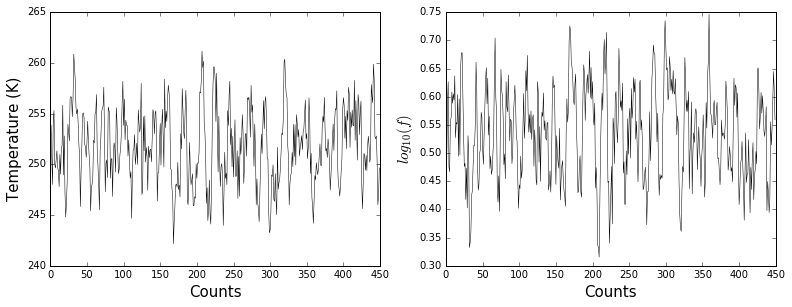

In [302]:
plt.figure(figsize=(13,10))

plt.subplot(221)
plt.plot(T[50:500],color='k',lw=0.5)
plt.xlabel('Counts',size=15)
plt.ylabel('Temperature (K)',size=15)


plt.subplot(222)
plt.plot(logf[50:500],color='k',lw=0.5)
plt.xlabel('Counts',size=15)
plt.ylabel('$log_{10}(f)$',size=15)


# Fitting Data to Planck Curve

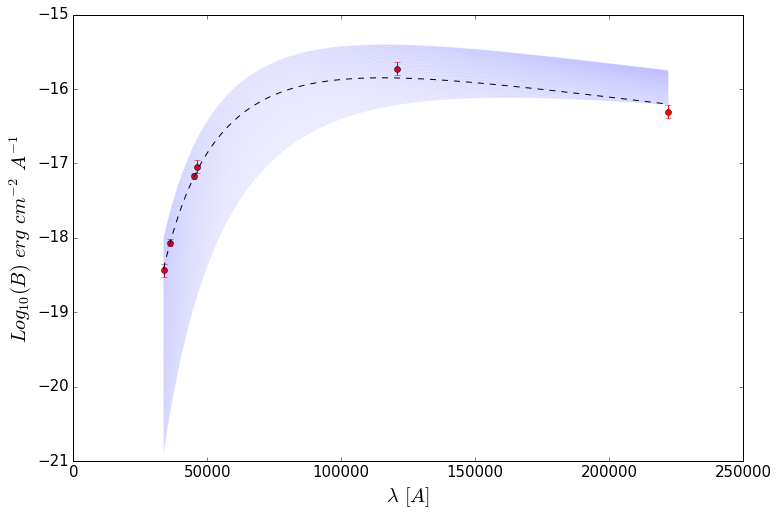

In [320]:
#note that the range is 
plt.figure(figsize=(12,8))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.errorbar(Lamda,log_flux,yerr=error,color='red',fmt='o',label='data')
plt.xlabel('$\lambda$ $[A]$',size=20)
plt.ylabel('$Log_{10}(B)$ $erg$ $cm^{-2}$ $A^{-1}$ ',size=20)

plt.plot(la,log_pf(la,251,0.54),alpha=1,lw=1,color='k',ls='dashed')

#if you would like to see the range of fit of temperatures 250-400 K 
for i in range (180,250):
    plt.plot(la,log_pf(la,i,1),alpha=0.1,color='blue')
   